# Классификация вин

In [1]:
# Импорт инструментария
import torch
import random
import numpy as np

import sklearn.datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

# Фиксируем зерна 
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Загрузка данных

In [2]:
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

Сэмплирование

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    wine.data,
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Посмотрим, как с задачей справится логистическая регрессия

In [7]:
log_reg = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)

log_reg.fit(X_train, y_train)

lr_train_preds = log_reg.predict(X_train)
lr_test_preds = log_reg.predict(X_test)

train_acc = metrics.accuracy_score(y_train, lr_train_preds)
test_acc = metrics.accuracy_score(y_test, lr_test_preds)
print(f'Final Train Accuracy: {round(train_acc, 5)}')
print(f'Final Test Accuracy: {round(test_acc, 5)}')

Final Train Accuracy: 0.98387
Final Test Accuracy: 0.94444


Напишем класс простой нейросетки и инициализируем модель

In [4]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(13, n_hidden_neurons)
        self.activ1 = torch.nn.ReLU()
        # Можно раскоммитить и добавить дополнительные слои
        # self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        # self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        # x = self.fc2(x)
        # x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(50)

Определим функцию ошибки и оптимизатор

In [6]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

Треннировка модели

In [7]:
batch_size = 16
n_epochs = 5000

test_accuracy_history = []
train_accuracy_history = []
test_loss_history = []
train_loss_history = []

for epoch in tqdm(range(n_epochs), desc="Processed"):
    order = np.random.permutation(len(X_train))
    for start_index in range(13, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    train_preds = wine_net.forward(X_train)
    train_loss_history.append(loss(train_preds, y_train))
    test_preds = wine_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    test_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(test_accuracy)
    train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean()
    train_accuracy_history.append(train_accuracy)

Processed: 100%|██████████| 5000/5000 [00:19<00:00, 254.58it/s]


Визуализируем динамику метрики и ошибки

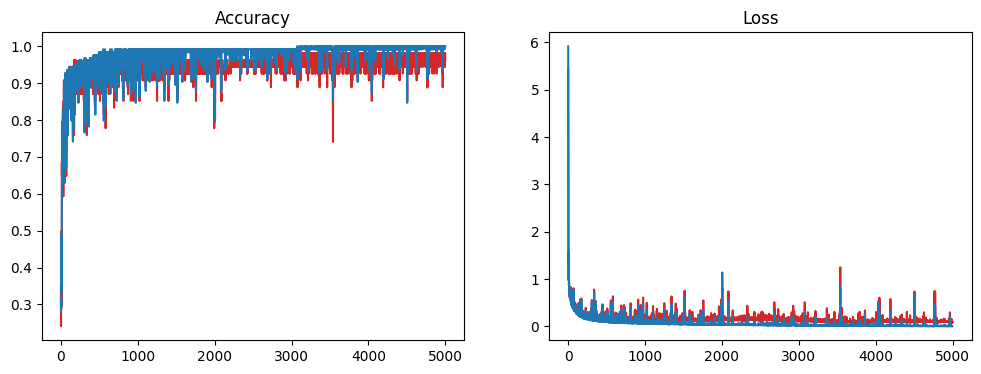

In [8]:
# Создаем подграфики
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 строка, 3 столбца

# Строим графики
axs[0].plot(test_accuracy_history, color='tab:red')
axs[0].plot(train_accuracy_history, color='tab:blue')
axs[0].set_title('Accuracy')

axs[1].plot([tnsr.item() for tnsr in test_loss_history], color='tab:red')
axs[1].plot([tnsr.item() for tnsr in train_loss_history], color='tab:blue')
axs[1].set_title('Loss')

# Отображаем графики
plt.show()

In [9]:
print(f'Final Train Accuracy: {round(train_accuracy_history[-1].item(), 5)}')
print(f'Final Test Accuracy: {round(test_accuracy_history[-1].item(), 5)}')

Final Train Accuracy: 1.0
Final Test Accuracy: 0.96296
